# Prepare Data
Here we prepare data as 1 min level kline for BTC from 2019.1.1 to 2020.5.2 in bitfinex exchange

In [1]:
#!python3 -m pip install -e .. -U
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.auto import tqdm, trange

In [2]:
TZ = 'Asia/Shanghai'

In [3]:
data_path = './data/data'
data_platform_list = ['BITFINEX']
data_symbol_list = ['BTC']

data_df_list = []

In [4]:
for platform in data_platform_list:
    for symbol in data_symbol_list:
        pkl_file_path = data_path+'/'+symbol+'_USD_'+platform+'_latest.pkl'
        pandas_df = pd.read_pickle(pkl_file_path)
        #data_df_list.append(pkl_file.add_prefix(platform+'_'+symbol+':'))
        data_df_list.append(pandas_df)
data = pd.concat(data_df_list, axis=1)

# Feature Enginnering

Tactical indicators etc.

In [5]:
data['timestamp'] = data.index.tolist()

In [6]:
data

,open,high,low,close,volume,timestamp
2019-01-01 16:00:00+08:00,3850.000000,3850.00000,3849.600000,3849.60000,0.443293,2019-01-01 16:00:00+08:00
2019-01-01 16:01:00+08:00,3849.500000,3853.00000,3849.400000,3853.00000,9.085920,2019-01-01 16:01:00+08:00
2019-01-01 16:02:00+08:00,3853.000000,3857.00000,3852.960000,3853.20000,8.213360,2019-01-01 16:02:00+08:00
2019-01-01 16:03:00+08:00,3853.000000,3853.10000,3851.200000,3852.20000,6.385190,2019-01-01 16:03:00+08:00
2019-01-01 16:04:00+08:00,3852.200000,3852.30000,3852.200000,3852.30000,0.504622,2019-01-01 16:04:00+08:00
...,...,...,...,...,...,...
2020-12-07 15:55:00+08:00,19398.841056,19402.00000,19398.841056,19402.00000,8.340088,2020-12-07 15:55:00+08:00
2020-12-07 15:56:00+08:00,19402.690321,19418.62931,19402.690321,19418.62931,2.047179,2020-12-07 15:56:00+08:00
2020-12-07 15:57:00+08:00,19412.000000,19419.00000,19412.000000,19419.00000,0.153671,2020-12-07 15:57:00+08:00
2020-12-07 15:58:00+08:00,19410.000000,19414.00000,19410.000000,19414.00000,0.633814,2020-12-07 15:58:00+08:00


In [7]:
# Prepare features
import talib

# Moving averages
data['ma5m'] = talib.MA(data['close'], timeperiod = 5) / data['close'] 
data['ma10m'] = talib.MA(data['close'], timeperiod = 10) / data['close'] 
data['ma1h'] = talib.MA(data['close'], timeperiod = 60) / data['close'] 
data['ma4h'] = talib.MA(data['close'], timeperiod = 240) / data['close'] 
data['ma12h'] = talib.MA(data['close'], timeperiod = 720) / data['close'] 
data['ma1d'] = talib.MA(data['close'], timeperiod = 1440) / data['close']
data['ma5d'] = talib.MA(data['close'], timeperiod = 7200) / data['close'] 
data['ma10d'] = talib.MA(data['close'], timeperiod = 14400) / data['close'] 
data['ma30d'] = talib.MA(data['close'], timeperiod = 43200) / data['close'] 


# Standard deviation
data['std5m'] = talib.STDDEV(data['close'], timeperiod=5)/ data['close'] 
data['std10m'] = talib.STDDEV(data['close'], timeperiod = 10) / data['close'] 
data['std1h'] = talib.STDDEV(data['close'], timeperiod = 60) / data['close'] 
data['std4h'] = talib.STDDEV(data['close'], timeperiod = 240) / data['close'] 
data['std12h'] = talib.STDDEV(data['close'], timeperiod = 720) / data['close'] 
data['std1d'] = talib.STDDEV(data['close'], timeperiod = 1440) / data['close']
data['std5d'] = talib.STDDEV(data['close'], timeperiod = 7200) / data['close'] 
data['std10d'] = talib.STDDEV(data['close'], timeperiod = 14400) / data['close'] 
data['std30d'] = talib.STDDEV(data['close'], timeperiod = 43200) / data['close'] 

# Closeness to hundred / thousand
data['dis100'] = (data['close'] % 100) / 100 
data['dis1000'] = (data['close'] % 1000) / 1000 

In [8]:
feature_set = ['ma5m','ma10m','ma1h','ma4h','ma12h','ma1d','ma5d','ma10d','ma30d', \
               'std5m','std10m','std1h','std4h','std12h','std1d','std5d','std10d','std30d',\
               'dis100', 'dis1000']

## Augment with same features in previous timestamps

In [9]:
new_feature_set = []
for feature in feature_set:
    data[f'{feature}_p1h'] = data[feature].shift(60)
    data[f'{feature}_p1d'] = data[feature].shift(1440)
    data[f'{feature}_p5d'] = data[feature].shift(7200)
    new_feature_set += [feature, f'{feature}_p1h', f'{feature}_p1d', f'{feature}_p5d']
feature_set = new_feature_set

In [10]:
print(f'Total feature number {len(feature_set)}')

Total feature number 80


## Show distribution of return in 1d 

C:\Users\Yuan\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Yuan\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([9.00000e+00, 5.60000e+01, 3.20000e+02, 1.95000e+02, 5.63000e+02,
        1.26600e+03, 3.88500e+03, 5.76200e+03, 1.46120e+04, 4.65010e+04,
        1.37749e+05, 3.97512e+05, 2.54872e+05, 7.25690e+04, 2.87060e+04,
        9.17900e+03, 6.52600e+03, 3.46900e+03, 1.22700e+03, 2.61000e+02,
        2.04000e+02, 1.23000e+02, 1.93000e+02, 2.68000e+02, 1.59000e+02,
        1.02000e+02, 9.70000e+01, 9.90000e+01, 6.60000e+01, 6.70000e+01,
        4.30000e+01, 8.80000e+01, 5.00000e+01, 3.00000e+01, 2.20000e+01,
        1.20000e+01, 1.00000e+01, 4.10000e+01, 4.10000e+01, 4.00000e+01,
        1.10000e+01, 3.00000e+00, 2.00000e+00, 4.00000e+00, 1.20000e+01,
        9.00000e+00, 3.00000e+00, 1.00000e+00, 3.00000e+00, 1.00000e+00]),
 array([-0.28686676, -0.26269117, -0.23851558, -0.21433999, -0.19016441,
        -0.16598882, -0.14181323, -0.11763764, -0.09346206, -0.06928647,
        -0.04511088, -0.0209353 ,  0.00324029,  0.02741588,  0.05159147,
         0.07576705,  0.09994264,  0.12411823,  0

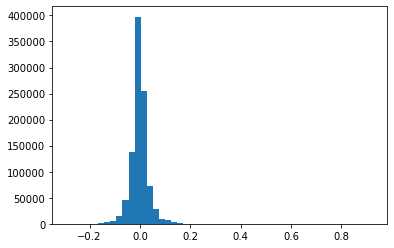

In [11]:
plt.hist(data['close'] / data['close'].shift(-1440) - 1,bins=50)

In [12]:
data['up_x%_in_1d_label'] = 100 * (data['close'] / data['close'].shift(-60) - 1)

In [13]:
data=data.dropna()

## Data Preparation

In [14]:
train_start_time = pd.Timestamp('2019-01-01', tz=TZ)
train_end_time = pd.Timestamp('2020-4-1', tz=TZ)
val_start_time = pd.Timestamp('2020-4-1', tz=TZ)
val_end_time = pd.Timestamp('2020-08-01', tz=TZ)
test_start_time = pd.Timestamp('2020-08-01', tz=TZ)
test_end_time = pd.Timestamp('2020-12-31', tz=TZ)

train_data = data.loc[train_start_time:train_end_time]
val_data = data.loc[val_start_time:val_end_time]
test_data = data.loc[test_start_time:test_end_time]

## Discritize continuous features

In [15]:
X_train = train_data[feature_set].values.squeeze().astype(np.float32)
X_val = val_data[feature_set].values.squeeze().astype(np.float32)
X_test = test_data[feature_set].values.squeeze().astype(np.float32)

In [16]:
from sklearn.preprocessing import KBinsDiscretizer

In [17]:
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
est.fit(X_train)

KBinsDiscretizer(encode='ordinal', strategy='uniform')

In [18]:
X_train = est.transform(X_train)
X_val = est.transform(X_val)
X_test = est.transform(X_test)

## Construct labels

In [19]:
label = ['up_x%_in_1d_label']

positive_threshold = 1

#Train
y_train = (train_data[label].values > positive_threshold).astype(int)
y_train_soft = np.zeros((len(y_train),2))
y_train_soft[:,1] = np.clip(1 + train_data[label].values.squeeze() - positive_threshold, 0, 1)
y_train_soft[:,0] = 1 - y_train_soft[:,1]

#Val
y_val = (val_data[label].values > positive_threshold).astype(int)
y_val_soft = np.zeros((len(y_val),2))
y_val_soft[:,1] = np.clip(1 + val_data[label].values.squeeze() - positive_threshold, 0, 1)
y_val_soft[:,0] = 1 - y_val_soft[:,1]

#Test
y_test = (test_data[label].values > positive_threshold).astype(int)
y_test_soft = np.zeros((len(y_test),2))
y_test_soft[:,1] = np.clip(0.5 + (test_data[label].values.squeeze()-positive_threshold), 0, 1)
y_test_soft[:,0] = 1 - y_test_soft[:,1]

In [20]:
print(f'Positive ratio in train set: {np.sum(y_train) / y_train.size}')
print(f'Positive ratio in val set: {np.sum(y_val) / y_val.size}')
print(f'Positive ratio in test set: {np.sum(y_test) / y_test.size}')

Positive ratio in train set: 0.04893900042177017
Positive ratio in val set: 0.032178778740390816
Positive ratio in test set: 0.032124593728161156


## Helper function

In [21]:
def plot_roc_from_fpr_tpr(fpr, tpr):
    lw = 2
    roc_auc = auc(fpr, tpr)
    #plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='(AUC = %0.3f)' % (roc_auc))
    #plt.plot([eer], [1-eer], marker='o', markersize=5, color="navy")
    #plt.plot([0, 1], [1, 0], color='navy', lw=1, linestyle=':')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")

# Dataset and Dataloader (PyTorch)

In [22]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data, labels):
        'Initialization'
        self.data = torch.from_numpy(data)
        self.labels = torch.from_numpy(labels.squeeze())

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]

        return X, y

In [23]:
class Dataset_indexed(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data, labels, ind):
        'Initialization'
        self.data = torch.from_numpy(data)
        self.labels = torch.from_numpy(labels.squeeze())
        self.ind = torch.from_numpy(ind.squeeze())

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]
        i = self.ind[index]

        return X, y, i

In [35]:
params = {'batch_size': 1024,
          'shuffle': True,
          'num_workers': 0,
          'pin_memory': True,
        }

In [36]:
train_set = Dataset(X_train, y_train)
train_set_soft = Dataset(X_train, y_train_soft)
train_loader = torch.utils.data.DataLoader(train_set, **params)
train_loader_soft = torch.utils.data.DataLoader(train_set_soft, **params)

val_set = Dataset(X_val, y_val)
val_set_soft = Dataset(X_val, y_val_soft)
val_loader = torch.utils.data.DataLoader(val_set, **params)
val_loader_soft = torch.utils.data.DataLoader(val_set_soft, **params)

test_set = Dataset(X_test, y_test)
test_set_soft = Dataset(X_test, y_test_soft)
test_loader = torch.utils.data.DataLoader(test_set, **params)
test_loader_soft = torch.utils.data.DataLoader(test_set_soft, **params)

# MLP Model (PyTorch)

In [37]:
# For reading, visualizing, and preprocessing data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier

### Define model

In [38]:
# define "soft" cross-entropy with pytorch tensor operations
class softXEnt(nn.Module):
    def __init__(self):
        super(softXEnt, self).__init__()

    def forward (self, input, target):
        logprobs = torch.nn.functional.log_softmax (input, dim = 1)
        return  -(target * logprobs).sum() / input.shape[0]

In [39]:
class Net(nn.Module):
    def __init__(self, num_inputs, action_space, hidden_size1=8, hidden_size2=8):
        super(Net, self).__init__()
        self.action_space = action_space
        num_outputs = action_space

        self.linear1 = nn.Linear(num_inputs, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, num_outputs)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.bn2 = nn.BatchNorm1d(hidden_size2)

    def forward(self, inputs):
        x = inputs
        x = self.bn1(F.relu(self.linear1(x)))
        x = self.bn2(F.relu(self.linear2(x)))
        out = self.linear3(x)

        return out

In [40]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
def train_indexed(model, device, train_loader, criterion, optimizer, epoch, sample_weight):
    model.train()
    for batch_idx, (data, target, index) in enumerate(train_loader):
        data, target, index = data.to(device), target.to(device), index.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        # reduction = 'none', to add in SR
        w = torch.from_numpy(sample_weight)
        #print(loss.size())
        #print(w[index].size())
        loss = (loss * w[index]).sum()/w[index].sum()
        loss.backward()
        optimizer.step()

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    
    label_gt = []
    label_pred = []
    label_pred_score = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * len(output)  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            if len(target.shape) > 1:
                target = target.argmax(dim=1, keepdim=False)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            label_gt += list(target.cpu().numpy())
            label_pred += list(pred.cpu().numpy())
            label_pred_score += list(output[:,1].cpu().numpy())

    test_loss /= len(test_loader.dataset)

    accuracy = correct / len(test_loader.dataset)
        
    
    fpr, tpr, _ = roc_curve(label_gt, label_pred_score)
    roc_auc = auc(fpr, tpr) 
    
    return (test_loss, accuracy, roc_auc, fpr, tpr)

In [41]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
input_dim = X_train.shape[1]
output_dim = 2
max_epochs = 10

### Initialize Sample Reweighting & Feature Selection

In [42]:
from sample_reweight import SampleReweight
from featureSelection import featureSelection

In [43]:
LIMITED_SAMPLE = False
EXAMPLES = 40000 if LIMITED_SAMPLE else X_train.shape[0]

# number of submodels
K = 5

# initialize sample weights and parameters
w = np.ones(X_train.shape[0])[:EXAMPLES]

ALPHA_1 = 1
ALPHA_2 = 1
NUM_BINS = 10
GAMMA = 0.9

# initialize feature selection parameters
NUM_BINS_FS = 3
ratio = [0.8, 0.6, 0.4]
feature_selected = np.arange(len(feature_set))

## Train with Hard Labels

### Single model

In [44]:
model_single = Net(input_dim, output_dim).to(device)
optimizer = optim.AdamW(model_single.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
#criterion = softXEnt().to(device)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

train_roc_auc_list = []
val_roc_auc_list = []

for epoch in tqdm(range(max_epochs)):
    train(model_single, device, train_loader, criterion, optimizer, epoch)
    (train_loss, train_accuracy, train_roc_auc, train_fpr, train_tpr) = test(model_single, device, train_loader, criterion)
    (val_loss, val_accuracy, val_roc_auc, val_fpr, val_tpr) = test(model_single, device, val_loader, criterion)
    train_roc_auc_list.append(train_roc_auc)
    val_roc_auc_list.append(val_roc_auc)
    scheduler.step()

RuntimeError: Expected object of scalar type Long but got scalar type Int for argument #2 'target' in call to _thnn_nll_loss_forward

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(train_roc_auc_list)
plt.plot(val_roc_auc_list)
plt.title('ROC AUC')
plt.legend(['train','val'])
plt.subplot(1, 2, 2)
plot_roc_from_fpr_tpr(val_fpr, val_tpr)

### 5 submodels

In [ ]:
clfs_5_sub = []
optmzs_5_sub = []
schedulers_5_sub = []

In [ ]:
criterion = nn.CrossEntropyLoss()
for i in tqdm(range(K)):
    # initiate submodel
    clfs_5_sub.append(Net(input_dim, output_dim).to(device))
    optmzs_5_sub.append(optim.AdamW(clfs_5_sub[i].parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False))
    schedulers_5_sub.append(StepLR(optmzs_5_sub[i], step_size=1, gamma=0.7))
    
    train_set = Dataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_set, **params)
    
    for epoch in tqdm(range(max_epochs)):
        train(clfs_5_sub[i], device, train_loader, criterion, optmzs_5_sub[i], epoch)
        schedulers_5_sub[i].step()

### +SR

In [ ]:
train_index = np.arange(X_train.shape[0])
train_set = Dataset_indexed(X_train, y_train, train_index)
train_set_soft = Dataset_indexed(X_train, y_train_soft, train_index)
train_loader = torch.utils.data.DataLoader(train_set, **params)
train_loader_soft = torch.utils.data.DataLoader(train_set_soft, **params)

In [ ]:
clfs_SR = []
optmzs_SR = []
schedulers_SR = []

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')

for i in tqdm(range(K)):
    # initiate submodel
    clfs_SR.append(Net(input_dim, output_dim).to(device))
    optmzs_SR.append(optim.AdamW(clfs_SR[i].parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False))
    schedulers_SR.append(StepLR(optmzs_SR[i], step_size=1, gamma=0.7))
    
    staged_pred = []
    train_set = Dataset_indexed(X_train, y_train, train_index)
    train_loader = torch.utils.data.DataLoader(train_set, **params)
    
    for epoch in tqdm(range(max_epochs)):
        train_indexed(clfs_SR[i], device, train_loader, criterion, optmzs_SR[i], epoch, sample_weight=w)
        schedulers_SR[i].step()
        with torch.no_grad():
            X_pred = torch.from_numpy(X_train)
            staged_pred.append((torch.nn.functional.log_softmax(clfs_SR[i](X_pred), dim = 1).numpy()))
    # initialize sample reweighting
    SR = SampleReweight(X_train, y_train, a1=ALPHA_1, a2=ALPHA_2, b=NUM_BINS, gamma=GAMMA)
    w = SR.reweight(clfs_SR[i], staged_pred)
    print(np.max(w))

### +SR+FS

In [ ]:
train_index = np.arange(X_train.shape[0])
train_set = Dataset_indexed(X_train, y_train, train_index)
train_set_soft = Dataset_indexed(X_train, y_train_soft, train_index)
train_loader = torch.utils.data.DataLoader(train_set, **params)
train_loader_soft = torch.utils.data.DataLoader(train_set_soft, **params)

In [ ]:
clfs_SR_FS = []
optmzs_SR_FS = []
schedulers_SR_FS = []

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')
list_feature_selected = []
list_feature_selected.append(feature_selected.copy())

for i in tqdm(range(K)):
    # initiate submodel
    input_dim = feature_selected.shape[0]
    clfs_SR_FS.append(Net(input_dim, output_dim).to(device))
    optmzs_SR_FS.append(optim.AdamW(clfs_SR_FS[i].parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False))
    schedulers_SR_FS.append(StepLR(optmzs_SR_FS[i], step_size=1, gamma=0.7))
    
    staged_pred = []
    train_set = Dataset_indexed(X_train[:, feature_selected], y_train, train_index)
    train_loader = torch.utils.data.DataLoader(train_set, **params)
    
    for epoch in tqdm(range(max_epochs)):
        train_indexed(clfs_SR_FS[i], device, train_loader, criterion, optmzs_SR_FS[i], epoch, sample_weight=w)
        schedulers_SR_FS[i].step()
        with torch.no_grad():
            X_pred = torch.from_numpy(X_train[:,feature_selected])
            staged_pred.append((torch.nn.functional.log_softmax(clfs_SR_FS[i](X_pred), dim = 1).numpy()))
    # initialize sample reweighting
    SR = SampleReweight(X_train[:, feature_selected], y_train, a1=ALPHA_1, a2=ALPHA_2, b=NUM_BINS, gamma=GAMMA)
    w = SR.reweight(clfs_SR_FS[i], staged_pred)
    print(np.max(w))
    
    #feature selection
    feature_selected_index = featureSelection(clfs_SR_FS[i], X_val[:, feature_selected], y_val, NUM_BINS_FS, ratio)
    feature_selected = feature_selected[feature_selected_index]
    print(feature_selected)
    list_feature_selected.append(feature_selected.copy())

## Evaluate Model

In [ ]:
decision_list = []
model_single.eval()
with torch.no_grad():
        X_test_tensor = torch.from_numpy(X_test)
        #softmax = torch.nn.functional.softmax(model_single(X_test_tensor), dim = 1)
        #decision_list.append(softmax.numpy()[:,1])
        decision_list.append((model_single(X_test_tensor)).numpy()[:,1])
print(len(decision_list))
print(np.asarray(decision_list).shape)
y_score_single = np.mean(np.asarray(decision_list), axis = 0)
print(y_score_single)

In [ ]:
decision_list = []
for i in range(K):
    clfs_5_sub[i].eval()
    with torch.no_grad():
        X_test_tensor = torch.from_numpy(X_test)
        #softmax = torch.nn.functional.softmax(clfs_5_sub[i](X_test_tensor), dim = 1)
        #decision_list.append(softmax.numpy()[:,1])
        decision_list.append((clfs_5_sub[i](X_test_tensor)).numpy()[:,1])
print(len(decision_list))
print(np.asarray(decision_list).shape)
y_score_5_sub = np.mean(np.asarray(decision_list), axis = 0)
print(y_score_5_sub)

In [ ]:
decision_list = []
for i in range(K):
    clfs_SR[i].eval()
    with torch.no_grad():
        X_test_tensor = torch.from_numpy(X_test)
        #softmax = torch.nn.functional.softmax(clfs_SR[i](X_test_tensor), dim = 1)
        #decision_list.append(softmax.numpy()[:,1])
        decision_list.append((clfs_SR[i](X_test_tensor)).numpy()[:,1])
print(len(decision_list))
print(np.asarray(decision_list).shape)
y_score_SR = np.mean(np.asarray(decision_list), axis = 0)
print(y_score_SR)

In [ ]:
decision_list = []
for i in range(K):
    clfs_SR_FS[i].eval()
    with torch.no_grad():
        X_test_tensor = torch.from_numpy(X_test[:,list_feature_selected[i]])
        #softmax = torch.nn.functional.softmax(clfs_SR_FS[i](X_test_tensor), dim = 1)
        #decision_list.append(softmax.numpy()[:,1])
        decision_list.append((clfs_SR_FS[i](X_test_tensor)).numpy()[:,1])
print(len(decision_list))
print(np.asarray(decision_list).shape)
y_score_SR_FS = np.mean(np.asarray(decision_list), axis = 0)
print(y_score_SR_FS)

In [ ]:
def plot_roc(labels, scores):
    lw = 2
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='(AUC = %0.3f)' % (roc_auc))
    #plt.plot([eer], [1-eer], marker='o', markersize=5, color="navy")
    #plt.plot([0, 1], [1, 0], color='navy', lw=1, linestyle=':')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")

In [ ]:
plot_roc(y_test, y_score_single)
plot_roc(y_test, y_score_5_sub)
plot_roc(y_test, y_score_SR)
plot_roc(y_test, y_score_SR_FS)